# Topological optimization of Total Persistence using (Stratified) Gradient Sampling.

Authors: Théo Lacombe & Mathieu Carrière.

## Introduction

### Goals

In this first tutorial, we will show how to use a Stratified Gradient descent (as well as Gradient Sampling descent) in the context of Topological Data Analysis when it comes to minimise the _total persistence_ of the _extended persistence diagram_ induced by a filter function $x$. 

The goal is two-fold:
- Provide a minimal working example on which one can use the `topt` module to simplify the total persistence of a filter function.
- Showcase the differences between _generalized gradient_ approaches with the Vanilla gradient descent. 

This tutorial is based on [this paper](https://arxiv.org/abs/2109.00530).

### Formalism and mathematical intuition

In order to focus on code-using and mathematical intuition, we introduce in this notebook a very simple model:

$x$ is a filter function defined on a line in $\mathbb{R}^N$, where $N=5$. This filter function induces an extended persistence diagrams (see this [gudhi tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-extended-persistence.ipynb) for an introduction to extended persistence), denoted by $D(x)$ in the following. 

Our goal is to optimize the filter function $x$ in order to minimize the _total persistence_ $\mathrm{Pers}(D(x))$ of $D(x)$, that is the distance between $D(x)$ and the empty diagram (or any diagram with points only belonging to the diagonal $\{x=y\} \subset \mathbb{R}^2$.
It is worth recalling that $D(x)$ is empty if, and only if, $x$ is constant (that is $\forall i \in \{1,\dots,N\}, x_i = x_1$). Doing so, we are substantially trying to flatten $x$. 

It is natural to try to minimize the map $x \mapsto \mathrm{Pers}(D(x))$ using a gradient descent algorithm. The main issue is that this map is differentiably if, and only if, $i \neq j \Rightarrow x_i \neq x_j$ (i.e.~$x$ has no equal entries). Though this specific situation will not occur numerically in practice, it means that the map $\mathrm{Pers}(D( \cdot ))$ has _non-differentiability strata_ which may hinder a Vanilla gradient descent approach : 
$$ x_{k+1} = x_k - \epsilon \nabla \mathrm{Pers}(D(x)). $$
In particular, $\| \nabla \mathrm{Pers}(D(x_k)) \|$ may not go to $0$, even if $x_k$ gets closer to a local minimum of our objective function. 
Actually, $x \mapsto \mathrm{Pers}(D(x))$ is not differentiable at the empty diagram, and the norm of its gradient will be larger than $1$ around this (unique) local minimum. 
Of importance, it prevents us to use the natural stopping criterion $\| \nabla \mathrm{Pers}(D(x))\| < \eta$ for some criterion. 

In a nutshell, minimizing this map is the TDA-equivalent to minimize the map $x \mapsto |x|$ over $\mathbb{R}$: a vanilla gradient descent is likely to bounce around the optimal value $x=0$, as $\nabla |x| \in \{-1,1\}$ for all $x \neq 0$. 

To improve on this, _generalized_ gradient descents techniques, such as the Gradient Sampling and the Stratified approaches, aim at estimating $\epsilon$-subgradient around the current iterate $x_k$; namely, the goal is to estimate

$$ g(x_k, \epsilon) := \mathrm{argmin} \{ \| u \|,\ u \in \mathrm{CvxHull}(\{\nabla z,\ z\in B(x_k, \epsilon) \}) \}$$

where $B(x_k,\epsilon)$ is the ball centered at $x_k$ of radius $\epsilon > 0$. 
The key point is that $g(x_k,\epsilon)$ always provide a descent direction for the objective map $F$ at $x_k$ and, furthermore:
- $g(x_k,\epsilon) = 0 \Leftrightarrow x_k \text{ is an optimum of } F$
- $x_k \to x_{\mathrm{min}}$ (where $x_{\mathrm{min}}$ minimizes $F$) $\Rightarrow \|g(x_k,\epsilon)\| \to 0$.

As one cannot exactly compute $g(x_k,\epsilon)$ in practice, it appears to be natural to sample points $x^1,\dots, x^m$ in $B(x_k,\epsilon)$, and define

$$ \tilde{g}(x_k,\epsilon) := \mathrm{argmin} \{ \|u\|,\ u \in \mathrm{CvxHull}(\{\nabla F(x^1),\dots, \nabla F(x^m)\}) \}.$$

An intuitive way to sample the points $x^1,\dots, x^m$ is to sample them randomly in $B(x_k,\epsilon)$. 
This approach is called **Gradient sampling** and it has been proven that, provided $m$ is large enough, using the resulting $\tilde{g}(x_k,\epsilon)$ to perform a gradient descent (with fixed step-size!) will converge to a local optimum of the objective map $F$, and furthermore $\|\tilde{g}(x_k,\epsilon)\| \to 0$ (almost surely), enabling the use of a stopping criterion. 

The gradient sampling approach has the benefits of being fairly simple to implement.
Nonetheless, it can be improved if one has access to a _stratification_ of the map $F$, that is when we know exactly the set of $x$ for which $\nabla F(x)$ exists. 
This occurs in Topological Data Analysis (and in particular when one minimizes the Total Persistence of a filter function) : the strata of the map $x \mapsto D(x)$ correspond to the $N!$ different ordering the coordinate of $x$ can have. 

In this situation, one can sample *one* point $x^i$ for each strata $S^i \subset \mathbb{R}^N$ that intersects $B(x_k,\epsilon)$ and compute an estimated generalized gradient $\tilde{g}(x_k,\epsilon)$. 
The resulting gradient descent enjoys the same properties as the gradient sampling one, in particular we have access to a stopping criterion $\|\tilde{g}(x_k,\epsilon)\| \leq \eta$ to detect nearby local optimum. 
The benefits of this approach are : 
- We do not need to sample $m$ points at each step : if $x_k$ belongs to an area where $F$ is smooth (i.e.~there is not non-differentiability area at distance $\leq \epsilon$), we know that we can simply use $\nabla F(x_k)$. Overall, this may reduce the computational complexity of the algorithm.
- From a theoretical perspective, we can obtain _convergence rates_ for this **Stratified Gradient Sampling Descent** algorithm, an improvment on usual gradient sampling approaches. 

Note that these two models are naturally more greedy in terms of computational ressources than the Vanilla Gradient descent. 

### About the TopoMeanModel

Minimizing total persistence can be seen as a particular case of minimization scheme provided by the `topt` library: the `TopoMeanModel`. 
Its idea is the following: we assume that one observe diagrams $D[1], \dots, D[m]$ (possibly coming from observation $x[1],\dots,x[m]$). 
Mimicking the concept of [_Fréchet mean_ (a.k.a barycenter) of persistence diagram](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-Barycenters-of-persistence-diagrams.ipynb), is it natural to seek for a minimizer of the map

$$ x \mapsto \sum_{i=1}^m \mathrm{dist}( D(x), D[i] )^p $$

where $\mathrm{dist}$ is any suitable metric between persistence diagrams (typically the Wasserstein distances between persistence diagrams). 

Using `topt`, this can be done by defining a `TopoMeanModel()` object, and then relying on `tensorflow` autodifferenciation machinery. 
Minimizing total persistence is a particular instance of this problem using $p=1$, $m=1$ and $D[1] = 0$ (where $0$ denotes the empty diagram).

## Imports

In [1]:
%matplotlib inline

Import from external libraries

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import tensorflow as tf

Imports from utils files

In [3]:
sys.path.append("../")
import utils.utils_perstot_minimization as uexpe
import topt

# Minimization of Total Persistence

Now, we define our initial $x$, from which our gradient descent schemes will start. 

In [4]:
np.random.seed(1)
N = 5
F, Finit, stbase, stbase_obs = uexpe.build_model(N=N)

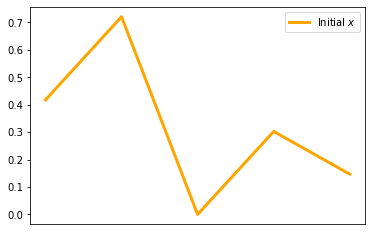

In [5]:
fig, ax = plt.subplots()
ax.plot(Finit, color='orange', linewidth=3, label='Initial $x$')
ax.set_xticks([])
ax.legend()

We define the target diagram (the null diagram). For the sake of simplicity, we put one point on the diagonal. 

In [6]:
target_diagram = np.array([[0.5, 0.5]])

We define some hyper-parameters of the problem.

In [7]:
dim = 0                    # homological dimension
order = 1.                 # loss is given by W_order^order.
epsilon = 1e-2             # we search for strata by looking 
                           # at miror points in range epsilon
extended = True            # We compute extended persistence diagrams.

Pick verbosity level.

In [8]:
verbosity_level = 0        # 0 : silent, 1 : standard, 2 : debug helper

Now, we will run `TopoMeanModel` to minimize total persistence for each gradient descent approach : vanilla, strata, and gradiant_sampling ones. 

We will store the result and visualize them afterwards.

In [9]:
#The different modes we will explore
modes = ['vanilla', 'gradient_sampling', 'strata']

# Lists to store the results

filter_function_lists = [[],[],[]]
diagrams_lists        = [[],[],[]]
gradient_lists        = [[],[],[]]
losses_lists          = [[],[],[]]

# An upperbound of the number of epoch we make; 
# With gradient_sampling and strata, we will reach the stopping criterion earlier;
# But for vanilla, we will never stop. 
num_epochs_max = 300

In [ ]:
for i, mode in enumerate(modes):
    """
    card_strata stores the number of points we sample around the current point. 
    For vanilla, it is 0. 
    For sampling, we sample N+1 points (where N is the dimension of the filter function).
    For strata, one should actually sample one point for each neighboring strata,
      however, this may be very large in some situation, so we can cap this number for 
      better memory management.
    """
    if mode == "gradient_sampling":
        card_strata = N + 1  # maximal number of strata we investigate
    elif mode == "strata": 
        card_strata = min(np.math.factorial(N), 120)
    elif mode == "vanilla":
        card_strata = 0
    
    
    # We instanciate the TopoMeanModel. 
    # See the doc for the role of the different parameters. 
    topomean = topt.TopoMeanModel(F=tf.Variable(initial_value=Finit, trainable=True), 
                                  diagrams=target_diagram, simplex=stbase, 
                                  dim = dim,
                                  mode = mode,
                                  card_strata = card_strata,
                                  epsilon = epsilon,
                                  order = 1.,
                                  extended = True,
                                  verbosity_level = verbosity_level)
   
    """
    Now, we rely on tensorflow autodiff framework, which will compute gradients
        (and check stopping criterion), and then apply the gradient. 
    It returns an history which allows us to investigate the gradient descent. 
    It also modify the state of topomean, so that (for instance) 
    the final filter function can be obtained calling `topomean.F`. 
    """
    history = topt.run_gradient_descent(topomean, num_epochs_max)
    
    filter_function_lists[i] = history['filter_functions']
    diagrams_lists[i] = history['diagrams']
    gradient_lists[i] = history['gradients']
    losses_lists[i] = history['losses_list']

## Let us visualize the results

In [11]:
# We define some color and abrev code. 
c = {'strata': 'green', 'sampling': 'blue', 'vanilla':'red', 'vanilla_decay':'brown'}
abrev = {'strata': 'SGS', 'sampling': 'GS', 'vanilla':'GD', 'vanilla_decay':'GDwD'}

In [12]:
# We apply a short preprocessing to the diagrals to improve rendering
# (we remove points very close to the diagonal)
diags_vanilla, diags_sampling, diags_strata = diagrams_lists
proc_diags_vanilla = [np.array([x for x in d if x[1]-x[0] > 1E-5]) for d in diags_vanilla]
proc_diags_strata = [np.array([x for x in d if x[1]-x[0] > 1E-5]) for d in diags_strata]

proc_diags_sampling = [np.array([x for x in d if x[1]-x[0] > 1E-5]) for d in diags_sampling]

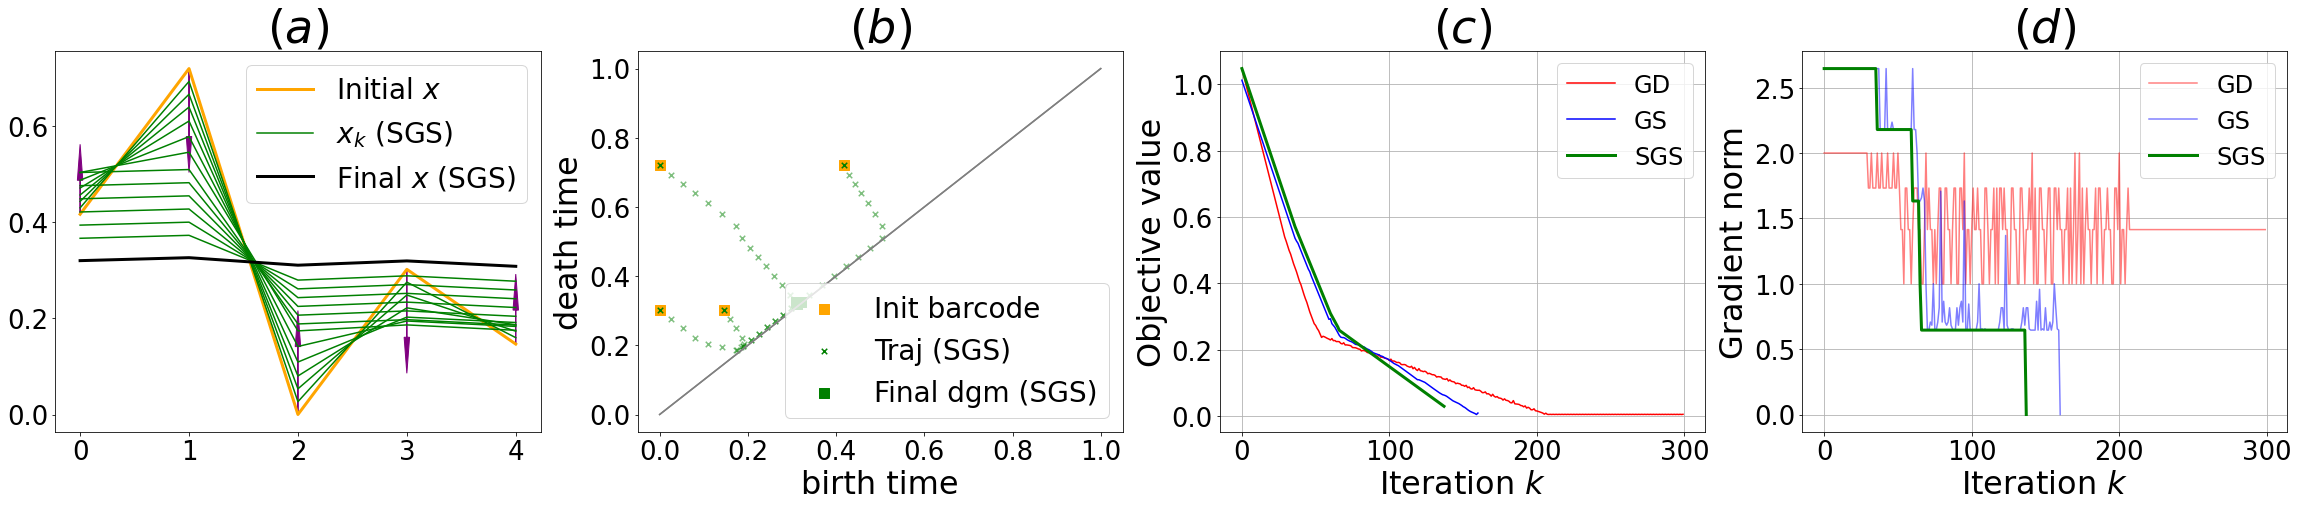

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(40,7))

# For better readability, we put result every step_size epoch.
step_size = 10

# Input filter function
axs[0].plot(Finit, color='orange', linewidth=3, label='Initial $x$')

# For better readability, we only plot func for strata. 
funcs_strata = filter_function_lists[2]
for i,f in enumerate(funcs_strata[10:-10:step_size]):
    if i == 0:
        axs[0].plot(f, color=c['strata'], label='$x_k$ (%s)' %abrev['strata'])
    else:
        axs[0].plot(f, color=c['strata'])
axs[0].plot(funcs_strata[-1], color='k', linewidth=3, label='Final $x$ (%s)' %abrev['strata'])

# We take the initial gradient for strata (i = 2). 
# Note that gradients are tuple for the form (coordinates, norms).
initial_grad = gradient_lists[2][0][0]
for i, v in enumerate(initial_grad):
    axs[0].arrow(i, Finit[i], 0, -v/10, color='purple', head_width=0.05)


# Diagrams and trajectories for strata GD 
# (results are substantially similar for other modes)
# Starting with the initial diagram
axs[1].scatter(proc_diags_strata[0][:,0], proc_diags_strata[0][:,1], 
               color='orange', marker='s', s=100, label='Init barcode')

        
for i, d in enumerate(proc_diags_strata[::10]):
    if i == 0:
        axs[1].scatter(d[:,0], d[:,1], color=c['strata'], alpha=1, marker='x', s=30, label='Traj (%s)' %abrev['strata'])
    elif len(d):
        axs[1].scatter(d[:,0], d[:,1], color=c['strata'], alpha=0.5, marker='x', s=30)
axs[1].scatter(proc_diags_strata[-1][:,0],proc_diags_strata[-1][:,1], 
               color='green', marker='s', s=100, label='Final dgm (%s)' %abrev['strata'])

axs[1].plot([[0,0],[1,1]], c='grey')

axs[1].set_xlabel('birth time', fontsize=32)
axs[1].set_ylabel('death time', fontsize=32)

end_vanilla = 300
loss_vanilla, loss_sampling, loss_strata = losses_lists
axs[2].plot(loss_vanilla[:end_vanilla], color=c['vanilla'], label=abrev['vanilla'])
axs[2].plot(loss_sampling, color=c['sampling'], label=abrev['sampling'])
axs[2].plot(loss_strata, color=c['strata'], label=abrev['strata'], linewidth=3)
axs[2].set_xlabel('Iteration $k$', fontsize=32)
axs[2].set_ylabel('Objective value', fontsize=32)

grad_vanilla, grad_sampling, grad_strata = [np.array([g[1] for g in gl]) 
                                                     for gl in gradient_lists]
axs[3].plot(grad_vanilla[:end_vanilla], color=c['vanilla'], label=abrev['vanilla'], alpha=0.5)
axs[3].plot(grad_sampling, color=c['sampling'], label=abrev['sampling'], alpha=0.5)
axs[3].plot(grad_strata, color=c['strata'], label=abrev['strata'], linewidth=3)
axs[3].set_xlabel('Iteration $k$', fontsize=32)
axs[3].set_ylabel('Gradient norm', fontsize=32)

for ax in axs[2:]:
    ax.grid()
    
for u, ax in zip(['a','b','c','d'], axs):
    ax.tick_params(labelsize=26)
    ax.set_title('($%s$)' %u, fontsize=46)

axs[0].legend(fontsize=28)
axs[1].legend(fontsize=28, loc='lower right')
axs[2].legend(fontsize=24, loc='upper right')
axs[3].legend(fontsize=24, loc='upper right')

Plot (a) shows the evolution of the filter function $x_k$ during the GD (for the SGS approach, but results would be substantially similar with other approaches). The final $x$ is almost flat; namely, it is $\epsilon$-close to a (in this case, global) minimizer of the total persistence map (that is, a constant filter function). 

On plot (b), we can see how the (extended) diagram of $x_k$ evolves, converging toward the empty diagram. 
<!-- Note that it does not follow a _geodesic_ in the space of persistence diagrams (which would yield straight lines toward the diagonal), which suggests that this geodesic is not feasible in the considered space of filter functions. -->

As one can see on plot (c) and (d), though Vanilla GD (red curve) decreases in a similar way as GS and SGS do, the norm of the gradient never goes to $0$, failing to reach a stopping criterion, hence running for the whole 300 epochs. 

On the opposite, both the Gradient Sampling and its stratified counterpart manage to build a generalized gradient whose norm goes (in this case, exactly) to $0$, enabling the use of a stopping criterion.